<a href="https://colab.research.google.com/github/VDeshmukhCemtrex/Pytorch/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=684c2159674e42e91d7be10f16211a141810f549d7aada05234f69b0f5345ade
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=4edbefcce95b619113727b5862d67f17ec4e7e20b1c877b37bfecf2c2535a43e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dp7ym545
  Running command git clone --filter=blob:n

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (3/3), done.


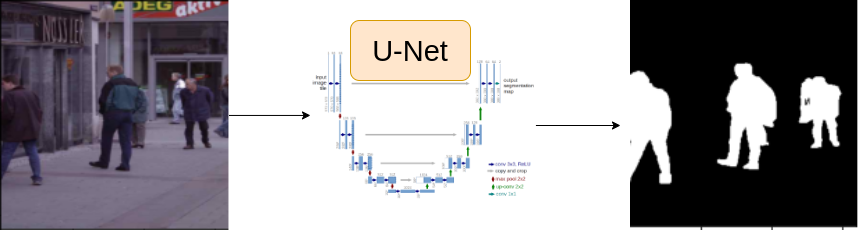

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
from os import WEXITED
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'
DEVICE='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[32]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0


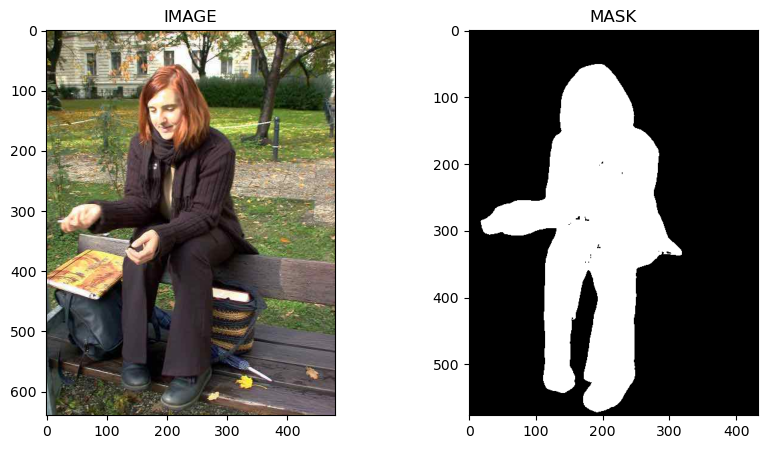

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)])
def get_valid_augs():
  return A.Compose([A.Resize(IMAGE_SIZE,IMAGE_SIZE),A.HorizontalFlip(p=0.5),A.VerticalFlip(p=0.5)])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row=self.df.iloc[index]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)
    
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask

In [ ]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


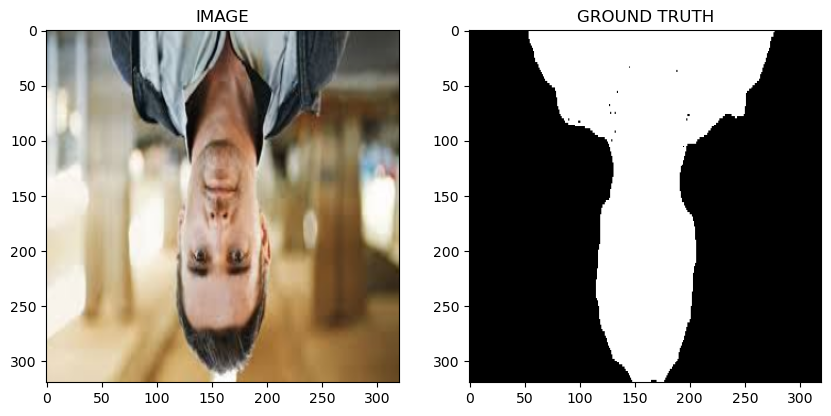

In [ ]:
index=32
image,mask=trainset[index]

helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
print(f'Total no.of batches in trainloader {len(trainloader)}')
print(f'Total no.of batches in validloader {len(validloader)}')

Total no.of batches in trainloader 15
Total no.of batches in validloader 4


In [ ]:
for image,mask in trainloader:
    break
    
print(f'First Batch image shape : {image.shape}')
print(f'First Batch mask shape : {mask.shape}')

First Batch image shape : torch.Size([16, 3, 320, 320])
First Batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()
        self.arc=smp.Unet(encoder_name=ENCODER,encoder_weights=WEIGHTS,in_channels=3,classes=1,activation=None)
    def forward(self,images,masks=None):
        logits=self.arc(images)
        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1+loss2
        return logits

In [ ]:
model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 123MB/s] 


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_loss=0.0
    for image,mask in data_loader:
        images=image.to(DEVICE)
        masks=mask.to(DEVICE)
        optimizer.zero_grad()
        logits,loss=model(images,masks)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    return total_loss/len(data_loader)

In [ ]:
def valid_fn(data_loader,model):
    model.eval()
    total_loss=0.0
    with torch.no_grad():
        for image,mask in tqdm(data_loader):
            images=image.to(DEVICE)
            masks=mask.to(DEVICE)
            model=model.to(DEVICE)
            logits,loss=model(images,masks)

            total_loss+=loss.item()
    return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
    train_loss=train_fn(trainloader,model,optimizer)
    valid_loss=valid_fn(validloader,model)
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved....')
        best_valid_loss=valid_loss
    print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Model Saved....
Epoch : 1 Train Loss : 0.3435579717159271 Valid Loss : 0.42110947519540787


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Model Saved....
Epoch : 2 Train Loss : 0.3517496724923452 Valid Loss : 0.3736361712217331


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Model Saved....
Epoch : 3 Train Loss : 0.29460992018381754 Valid Loss : 0.23476656153798103


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 4 Train Loss : 0.20935947994391124 Valid Loss : 0.24083228781819344


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Model Saved....
Epoch : 5 Train Loss : 0.19891925454139708 Valid Loss : 0.1910506747663021


100%|██████████| 4/4 [00:00<00:00,  4.60it/s]


Epoch : 6 Train Loss : 0.18629944721857708 Valid Loss : 0.2195434384047985


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 7 Train Loss : 0.221301931142807 Valid Loss : 0.20439335331320763


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 8 Train Loss : 0.2194606453180313 Valid Loss : 0.22082588076591492


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch : 9 Train Loss : 0.153769089281559 Valid Loss : 0.19695742055773735


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Epoch : 10 Train Loss : 0.16815650165081025 Valid Loss : 0.22423619776964188


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch : 11 Train Loss : 0.15354070961475372 Valid Loss : 0.20418507233262062


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Model Saved....
Epoch : 12 Train Loss : 0.15338927110036213 Valid Loss : 0.16546913236379623


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch : 13 Train Loss : 0.1711602543791135 Valid Loss : 0.1978301852941513


100%|██████████| 4/4 [00:00<00:00,  4.23it/s]


Epoch : 14 Train Loss : 0.1551977773507436 Valid Loss : 0.18276698514819145


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch : 15 Train Loss : 0.13981515914201736 Valid Loss : 0.18628620728850365


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch : 16 Train Loss : 0.1426742027203242 Valid Loss : 0.23359253630042076


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch : 17 Train Loss : 0.18816649715105693 Valid Loss : 0.2609096094965935


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 18 Train Loss : 0.1524370049436887 Valid Loss : 0.1803944632411003


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 19 Train Loss : 0.1205903912583987 Valid Loss : 0.21934090182185173


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 20 Train Loss : 0.13421157350142796 Valid Loss : 0.1757575310766697


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 21 Train Loss : 0.11032072653373083 Valid Loss : 0.16900468990206718


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


Epoch : 22 Train Loss : 0.12644952833652495 Valid Loss : 0.2907257676124573


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 23 Train Loss : 0.10775086879730225 Valid Loss : 0.17867586389183998


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 24 Train Loss : 0.098748117685318 Valid Loss : 0.21420666947960854


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Model Saved....
Epoch : 25 Train Loss : 0.09809948454300563 Valid Loss : 0.16536704450845718



# Task 9 : Inference

In [ ]:
index=32
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[index]
logits_masks=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_masks)
pred_mask=(pred_mask>0.5)*1.0

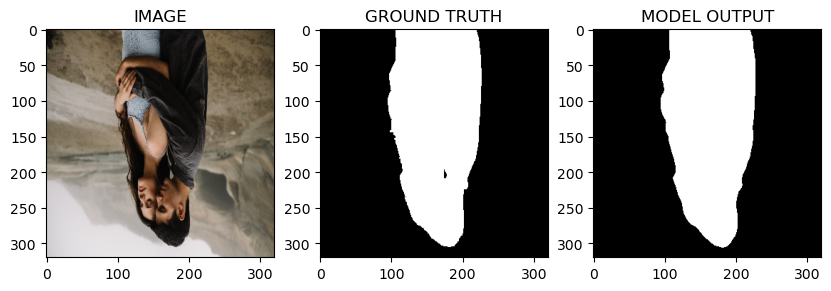

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))